In [1]:
from sympy import MatrixSymbol, Matrix, Identity

import sympy as sym
import pandas as pd
import math

sym.init_printing()
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import control
import random

# IDENTIFICACIÓN DE SISTEMAS

Profesor: Jairo Alberto Cuéllar Guarnizo  
Programa: Ingeniería en Automatización y Control

## Ejemplo 1

Dada una señal de entrada y salida, obtenga el modelo estimado usando el modelo ARMAX.

In [3]:
## Sistema de segundo orden en tiempo continuo
tf = 7
dt = 0.1
g = control.tf([1],[1,1,5,3])
t = np.linspace(0,tf,int(tf/dt)+1)
A = 2
# Señal de salida ideal "y"
_,y = control.step_response(g,t)
N = len(t)
u = A*np.ones(N)
## Ruido para simular la señal de salida capturada "yn"
r = 0.0
e = np.random.normal(0,1,size=N)
yn = A*y+e*r

gd = control.c2d(g,dt)
print(gd)

#a = np.asarray([t,yn])
#a = a.transpose()
#np.savetxt('data\clase_09.csv', a, delimiter=",")

data = {'t':t,'yn':yn,'un':u}
df = pd.DataFrame(data)
df.to_csv('data\exercise_05.csv',index = False)


0.0001622 z^2 + 0.0006312 z + 0.0001543
---------------------------------------
  z^3 - 2.856 z^2 + 2.764 z - 0.9048

dt = 0.1



,t,yn,un
0,0.0,0.000000,2.0
1,0.1,0.000324,2.0
2,0.2,0.002513,2.0
3,0.3,0.008177,2.0
4,0.4,0.018595,2.0
...,...,...,...
66,6.6,0.603861,2.0
67,6.7,0.610574,2.0
68,6.8,0.619198,2.0
69,6.9,0.629291,2.0


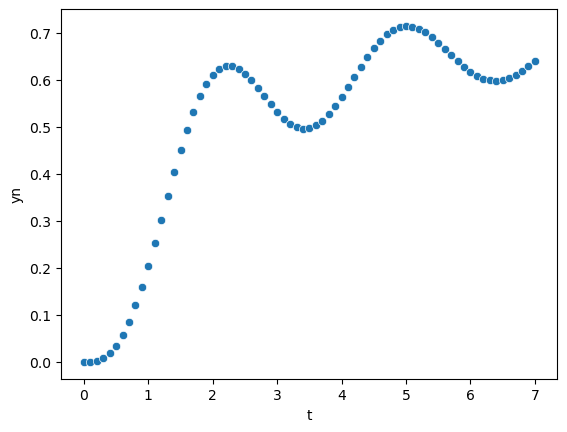

In [4]:
datos = pd.read_csv ('data\exercise_05.csv')
sns.scatterplot(datos,x ='t',y = 'yn' )
datos